#**Ciencia de Datos Aplicada MINE-4101 - QUIZ 2**
Universidad de los Andes  
Realizado por: Yeimy A. Cano M.

# **0. Importación de librerias de trabajo**

Primero se procede a hacer la importación de librerías para poder trabajar con los datos y poder realizar el análisis.

In [328]:
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [329]:
import numpy as np
import pandas as pd

from pandas_profiling import ProfileReport

import seaborn as sns
from scipy import stats
import scipy
import statsmodels.api as sm

#Entrenamiento del modelo
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures , OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso, Ridge

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.dpi'] = 110    

# **Entendimiento del Negocio**




Medical Cost Personal, se busca calcular el valor de seguro de una persona a partir de algunos datos.

# **Entendimiento de los datos**

## **a. Adquisición e integración de datos.**

El archivo de datos está como archivo de CSV, separado por ';'

Para trabajar con los datos, éstos se ubican en la misma carpeta de github para entrega del prente taller.

In [330]:
# Loading data
url = 'https://raw.githubusercontent.com/yacanom/CDA_MINE-4101_repo/main/Quiz2/data/insurance.csv'
data = pd.read_csv(url, sep=',')

In [331]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## **b. Diccionario de datos.**

| Field | Description| 
| --- | --- |
|age| age of primary beneficiary  |
|sex| insurance contractor gender: female, male  |
|bmi| Body mass index, providing an understanding of body, weights that are relatively high or low relative to height objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
|children| Number of children covered by health insurance / Number of dependents  |
|smoker| Smoking  |
|region| the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.  |
|charges| Individual medical costs billed by health insurance  |

## **c. Exploración de datos.**

Vamos a hacer una exploración sobre el set de datos entregados, con data.info se puede hacer una ojeada muy superficial para conocer tipos de datos, cantidad, sin tener mucha información detallada que entienda el modelo.

In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Se observan que todos las columnas tienen 1338 datos por lo que no se identifican datos faltantes.

Se identifican las características categóricas: sex, smoker y region.

In [333]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Dividimos los datos en: datos de entrenamiento (train) y datos de evaluación (test) con una relación 80% - 20% respectivamente, esto teniendo en cuenta de no buscar entregar información completa de la data actual y que el modelo la tenga de antemano. Adicionalmente, el conjunto de datos *test* nos permitirá hacer la evaluación final del modelo que nos podrá corroborar la precisión que tiene con datos no vistos anteriormente.


In [334]:
train, test = train_test_split(data, test_size=0.2, random_state=33)
train.head()

,age,sex,bmi,children,smoker,region,charges
1219,38,female,30.210,3,no,northwest,7537.16390
162,54,male,39.600,1,no,southwest,10450.55200
196,39,female,32.800,0,no,southwest,5649.71500
673,41,female,31.020,0,no,southeast,6185.32080
923,34,male,35.815,0,no,northwest,4320.41085


In [335]:
test.head()

,age,sex,bmi,children,smoker,region,charges
663,18,male,33.660,0,no,southeast,1136.39940
526,19,female,30.590,2,no,northwest,24059.68019
790,39,female,41.800,0,no,southeast,5662.22500
20,60,female,36.005,0,no,northeast,13228.84695
229,47,male,25.460,2,no,northeast,9225.25640


Ahora usamos ProfileReport para poder hacer la exploración sobre el data set de entrenamiento (train), para no dar la información del dataset completo. 

In [336]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [337]:
#Ubicar cantidad de datos duplicados:
df=data
print(df[df.duplicated()])

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


## d. Preparación de los datos

De acuerdo a la exploración de datos, se debe eliminar el registro duplicado, pasar las variables categóricas a numéricas.

In [338]:
#Eliminar los registros filas con datos faltantes
train= train.dropna(axis=0)
train.reset_index()

#Eliminar datos duplicados, solo es 1
train.drop_duplicates()
train.reset_index()

#Reemplazar la columna sex por su valor categórico 
train['sex'] = train['sex'].replace({
    "male": 0,
    "female": 1
})

#Reemplazar la columna smoker por su valor categórico 
train['smoker'] = train['smoker'].replace({
    "no": 0,
    "yes": 1
})
train.reset_index()

#encoder para region
train = pd.get_dummies(train,columns=['region'],drop_first = True)

In [339]:
train.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
1219,38,1,30.210,3,0,7537.16390,1,0,0
162,54,0,39.600,1,0,10450.55200,0,0,1
196,39,1,32.800,0,0,5649.71500,0,0,1
673,41,1,31.020,0,0,6185.32080,0,1,0
923,34,0,35.815,0,0,4320.41085,1,0,0


Ahora los mismos ajustes con la data de evaluación (test)

In [340]:
from numpy.core.numeric import tensordot
#Eliminar los registros filas con datos faltantes
test= test.dropna(axis=0)
test.reset_index()

#Eliminar datos duplicados, solo es 1
test.drop_duplicates()
test.reset_index()

#Reemplazar la columna sex por su valor categórico 
test['sex'] = test['sex'].replace({
    "male": 0,
    "female": 1
})

#Reemplazar la columna smoker por su valor categórico 
test['smoker'] = test['smoker'].replace({
    "no": 0,
    "yes": 1
})
test.reset_index()

#encoder para region
test = pd.get_dummies(test,columns=['region'],drop_first = True)

In [341]:
#separando la variable objetivo:
x_train = train.drop('charges',axis=1)
y_train = train['charges']

#separando la variable objetivo:
x_test = test.drop('charges',axis=1)
y_test = test['charges']

In [342]:
#escalando los datos de entrenamiento
scaler = MinMaxScaler()
col = x_train.columns
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_train.columns = col
x_train.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,0.434783,1.0,0.389132,0.6,0.0,1.0,0.0,0.0
1,0.782609,0.0,0.645549,0.2,0.0,0.0,0.0,1.0
2,0.456522,1.0,0.459858,0.0,0.0,0.0,0.0,1.0
3,0.500000,1.0,0.411251,0.0,0.0,0.0,1.0,0.0
4,0.347826,0.0,0.542190,0.0,0.0,1.0,0.0,0.0


In [343]:
#escalando los datos test
scaler = MinMaxScaler()
col = x_train.columns
x_test = pd.DataFrame(scaler.fit_transform(x_test))
x_test.columns = col
x_test.head()

,age,sex,bmi,children,smoker,region_northwest,region_southeast,region_southwest
0,0.000000,0.0,0.463858,0.0,0.0,0.0,1.0,0.0
1,0.021739,1.0,0.379320,0.4,0.0,1.0,0.0,0.0
2,0.456522,1.0,0.688008,0.0,0.0,0.0,1.0,0.0
3,0.913043,1.0,0.528432,0.0,0.0,0.0,0.0,0.0
4,0.630435,0.0,0.238056,0.4,0.0,0.0,0.0,0.0


# **Modelamiento**

##a) Entrene un primer modelo de regresión lineal sin aplicar ningún tipo de regularización. 

In [344]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(-2220.5562010268804,
 array([11787.08063596,   401.87259498, 13001.79354555,  2654.05882964,
        24253.36330944,  -631.79658228, -1575.93021477, -1288.31597288]))

In [345]:
y_pred_train = lin_reg.predict(x_train)


In [346]:
y_pred_test = lin_reg.predict(x_test)


In [347]:
#Función para ver los resultados de las métricas de un modelo entrenamiento y validación
def metricsPrint (titulo, X_train, y_train, y_pred_train, X_val, y_val, y_pred_val):
  n,p = X_train.shape

  print('------------ Regresión ', titulo,' con data entrenamiento------------')
  print("Residual sum of squares (MSE): %.2f" % mean_squared_error(y_train,y_pred_train))
  print("R2-score: %.5f" % r2_score(y_train, y_pred_train) )
  print("Adj R2-score: %.5f" % ( 1-(1-r2_score(y_train, y_pred_train))*(n-1)/(n-p-1)) )

  n,p = X_val.shape

  print('------------ Regresión ', titulo, ' con data test ------------')
  print("Residual sum of squares (MSE): %.2f" % mean_squared_error(y_val,y_pred_val))
  print("R2-score: %.5f" % r2_score(y_val, y_pred_val) )
  print("Adj R2-score: %.5f" % ( 1-(1-r2_score(y_val, y_pred_val))*(n-1)/(n-p-1)) )

In [348]:
metricsPrint ('Regresion Lineal', x_train, y_train, y_pred_train, x_test, y_test, y_pred_test)

------------ Regresión  Regresion Lineal  con data entrenamiento------------
Residual sum of squares (MSE): 36291133.66
R2-score: 0.76086
Adj R2-score: 0.75906
------------ Regresión  Regresion Lineal  con data test ------------
Residual sum of squares (MSE): 37787076.30
R2-score: 0.69874
Adj R2-score: 0.68943


i. ¿Es aceptable el error obtenido?

La variable objetivo está en un rango de: 1121.8739 - 63770.42801, por lo que un error MSE de 36291133.66 es bastante alto, posiblemente por valores extremos-

ii. ¿Hay evidencia de overfitting?

Al comparar las diferencias de la métrica R2-score, se observa que la diferencia de predicción de los datos de entrenamiento vs los datos de test, es del 7%, lo que muestra un pequeño sobreajuste del modelo.

##b) Aplique una transformación polinomial a los datos de entrada y regularización Ridge o Lasso al modelo de regresión.

### i. con grado 3 polinomial.

In [349]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
x_poly_train = poly_features.fit_transform(x_train)
dataset = pd.DataFrame(x_poly_train)
dataset


,0,1,2,3,4,5,6,7,8,9,...,154,155,156,157,158,159,160,161,162,163
0,0.434783,1.0,0.389132,0.6,0.0,1.0,0.0,0.0,0.189036,0.434783,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.782609,0.0,0.645549,0.2,0.0,0.0,0.0,1.0,0.612476,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.456522,1.0,0.459858,0.0,0.0,0.0,0.0,1.0,0.208412,0.456522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.500000,1.0,0.411251,0.0,0.0,0.0,1.0,0.0,0.250000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.347826,0.0,0.542190,0.0,0.0,1.0,0.0,0.0,0.120983,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.326087,1.0,0.651557,0.2,0.0,0.0,1.0,0.0,0.106333,0.326087,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1066,0.652174,1.0,0.544784,0.2,0.0,0.0,0.0,0.0,0.425331,0.652174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1067,0.739130,0.0,0.388859,0.2,0.0,0.0,0.0,1.0,0.546314,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1068,0.021739,1.0,0.586292,0.0,0.0,1.0,0.0,0.0,0.000473,0.021739,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se escoge utilizar una regularización Lasso, y los 3 diferentes valores de alfa a revisar son: 0.1, 10 y 200

In [350]:
LassoModel = Lasso(alpha=0.10)
LassoModel.fit(x_poly_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e+09, tolerance: 1.624e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.1)

Evaluación:

In [351]:
y_pred_lass_train_1 = LassoModel.predict(x_poly_train)
y_pred_lass_train_1

array([ 8118.34732444, 11986.36582011,  6749.30696824, ...,
       10937.22475969,  2381.27814629, 13976.68325909])

In [352]:
x_poly_test = poly_features.fit_transform(x_test)
y_pred_lass_test_1 = LassoModel.predict(x_poly_test)


In [353]:
metricsPrint ('Regresion Lasso alfa = 0.10', x_poly_train, y_train, y_pred_lass_train_1, x_poly_test, y_test, y_pred_lass_test_1)

------------ Regresión  Regresion Lasso alfa = 0.10  con data entrenamiento------------
Residual sum of squares (MSE): 20153529.17
R2-score: 0.86720
Adj R2-score: 0.84313
------------ Regresión  Regresion Lasso alfa = 0.10  con data test ------------
Residual sum of squares (MSE): 26138893.97
R2-score: 0.79160
Adj R2-score: 0.45979


Ahora alfa = 10

In [354]:
LassoModel = Lasso(alpha=10)
LassoModel.fit(x_poly_train, y_train)

Lasso(alpha=10)

In [355]:
y_pred_lass_train_2 = LassoModel.predict(x_poly_train)
y_pred_lass_train_2

array([ 9614.3478102 , 11765.26674817,  6938.10801834, ...,
       10819.51468494,  3695.68774805, 13236.82657214])

In [356]:
x_poly_test = poly_features.fit_transform(x_test)
y_pred_lass_test_2 = LassoModel.predict(x_poly_test)


In [357]:
metricsPrint ('Regresion Lasso alfa = 10', x_poly_train, y_train, y_pred_lass_train_2, x_poly_test, y_test, y_pred_lass_test_2)

------------ Regresión  Regresion Lasso alfa = 10  con data entrenamiento------------
Residual sum of squares (MSE): 22025302.33
R2-score: 0.85486
Adj R2-score: 0.82856
------------ Regresión  Regresion Lasso alfa = 10  con data test ------------
Residual sum of squares (MSE): 23812544.36
R2-score: 0.81015
Adj R2-score: 0.50787


Ahora alfa = 200

In [358]:
LassoModel = Lasso(alpha=200)
LassoModel.fit(x_poly_train, y_train)

Lasso(alpha=200)

In [359]:
y_pred_lass_train_3 = LassoModel.predict(x_poly_train)
y_pred_lass_train_3

array([ 8071.78609568, 11879.57026939,  8289.76582442, ...,
       11366.25125441,  4437.00972954, 12140.23113331])

In [360]:
x_poly_test = poly_features.fit_transform(x_test)
y_pred_lass_test_3 = LassoModel.predict(x_poly_test)


In [361]:
metricsPrint ('Regresion Lasso alfa = 200', x_poly_train, y_train, y_pred_lass_train_3, x_poly_test, y_test, y_pred_lass_test_3)

------------ Regresión  Regresion Lasso alfa = 200  con data entrenamiento------------
Residual sum of squares (MSE): 26870959.86
R2-score: 0.82293
Adj R2-score: 0.79085
------------ Regresión  Regresion Lasso alfa = 200  con data test ------------
Residual sum of squares (MSE): 26211618.21
R2-score: 0.79103
Adj R2-score: 0.45829


### ii. con grado 5 polinomial.

In [362]:
poly_features = PolynomialFeatures(degree=5, include_bias=False)
x_poly_train = poly_features.fit_transform(x_train)
dataset = pd.DataFrame(x_poly_train)
dataset


,0,1,2,3,4,5,6,7,8,9,...,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285
0,0.434783,1.0,0.389132,0.6,0.0,1.0,0.0,0.0,0.189036,0.434783,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.782609,0.0,0.645549,0.2,0.0,0.0,0.0,1.0,0.612476,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.456522,1.0,0.459858,0.0,0.0,0.0,0.0,1.0,0.208412,0.456522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.500000,1.0,0.411251,0.0,0.0,0.0,1.0,0.0,0.250000,0.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.347826,0.0,0.542190,0.0,0.0,1.0,0.0,0.0,0.120983,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.326087,1.0,0.651557,0.2,0.0,0.0,1.0,0.0,0.106333,0.326087,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1066,0.652174,1.0,0.544784,0.2,0.0,0.0,0.0,0.0,0.425331,0.652174,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1067,0.739130,0.0,0.388859,0.2,0.0,0.0,0.0,1.0,0.546314,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1068,0.021739,1.0,0.586292,0.0,0.0,1.0,0.0,0.0,0.000473,0.021739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se escoge utilizar una regularización Lasso, y los 3 diferentes valores de alfa a revisar son: 0.5, 50 y 300

In [363]:
LassoModel = Lasso(alpha=0.50)
LassoModel.fit(x_poly_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e+09, tolerance: 1.624e+07
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.5)

Evaluación:

In [364]:
y_pred_lass_train_4 = LassoModel.predict(x_poly_train)
y_pred_lass_train_4

array([ 8951.25716631, 11930.80288902,  6437.43604247, ...,
       10886.288709  ,  1649.33172356, 14255.07717934])

In [365]:
x_poly_test = poly_features.fit_transform(x_test)
y_pred_lass_test_4 = LassoModel.predict(x_poly_test)


In [366]:
metricsPrint ('Regresion Lasso alfa = 0.50', x_poly_train, y_train, y_pred_lass_train_4, x_poly_test, y_test, y_pred_lass_test_4)

------------ Regresión  Regresion Lasso alfa = 0.50  con data entrenamiento------------
Residual sum of squares (MSE): 18285926.96
R2-score: 0.87950
Adj R2-score: 1.59359
------------ Regresión  Regresion Lasso alfa = 0.50  con data test ------------
Residual sum of squares (MSE): 26386428.75
R2-score: 0.78963
Adj R2-score: 1.05512


Ahora alfa = 50

In [367]:
LassoModel = Lasso(alpha=50)
LassoModel.fit(x_poly_train, y_train)

Lasso(alpha=50)

In [368]:
y_pred_lass_train_5 = LassoModel.predict(x_poly_train)
y_pred_lass_train_5

array([ 8937.06537817, 11622.97012457,  7029.33694716, ...,
       10938.84759061,  3917.84638667, 12619.30057462])

In [369]:
x_poly_test = poly_features.fit_transform(x_test)
y_pred_lass_test_5 = LassoModel.predict(x_poly_test)


In [370]:
metricsPrint ('Regresion Lasso alfa = 50', x_poly_train, y_train, y_pred_lass_train_5, x_poly_test, y_test, y_pred_lass_test_5)

------------ Regresión  Regresion Lasso alfa = 50  con data entrenamiento------------
Residual sum of squares (MSE): 23192229.05
R2-score: 0.84717
Adj R2-score: 1.75286
------------ Regresión  Regresion Lasso alfa = 50  con data test ------------
Residual sum of squares (MSE): 23348769.72
R2-score: 0.81385
Adj R2-score: 1.04878


Ahora alfa = 300

In [371]:
LassoModel = Lasso(alpha=330)
LassoModel.fit(x_poly_train, y_train)

Lasso(alpha=330)

In [372]:
y_pred_lass_train_6 = LassoModel.predict(x_poly_train)
y_pred_lass_train_6

array([ 8409.32031306, 11603.39459827,  8599.64028429, ...,
       11186.75725897,  5029.0858736 , 11813.57520224])

In [373]:
x_poly_test = poly_features.fit_transform(x_test)
y_pred_lass_test_6 = LassoModel.predict(x_poly_test)


In [374]:
metricsPrint ('Regresion Lasso alfa = 300', x_poly_train, y_train, y_pred_lass_train_6, x_poly_test, y_test, y_pred_lass_test_6)

------------ Regresión  Regresion Lasso alfa = 300  con data entrenamiento------------
Residual sum of squares (MSE): 31800573.72
R2-score: 0.79045
Adj R2-score: 2.03230
------------ Regresión  Regresion Lasso alfa = 300  con data test ------------
Residual sum of squares (MSE): 30645771.48
R2-score: 0.75567
Adj R2-score: 1.06402


### Conclusiones: Polinomial y lasso 

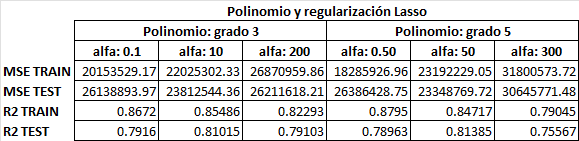



i. ¿Fue posible mejorar el error? ¿Qué hiper-parámetros tiene el modelo que produce el menor error?

En comparación del valor obtenido como error con los datos de evaluación del modelo lineal, efectivamente si se ve que disminuye, aunque los errores siguen siendo altos para el rango que maneja la variable. 

El modelo con el menor error es el del polinomi grado 5 con un alfa de 50 para la regularización Lasso.

ii. ¿Qué atributos parecen ser los más importantes para realizar la predicción?





In [375]:
LassoModel = Lasso(alpha=50)
LassoModel.fit(x_poly_train, y_train)

Lasso(alpha=50)

In [376]:
print(f'Intercepto: {LassoModel.intercept_}')
coef = list(LassoModel.coef_)
coef


Intercepto: 3501.3462394500257


[4968.099392065615,
 0.0,
 0.0,
 2721.73505408223,
 4654.073592158952,
 -124.45675700517322,
 -8.669337541251629,
 -630.4946454949343,
 7075.272412741073,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.6047194700587001,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 46020.21876296451,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 3.956876175963368,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -503.2818916937805,
 0.0,
 -12.912153356214514,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 379.3444202637647,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 -0.0,
 1509.753163946566,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0